### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import tensorflow.keras.backend as K
import time  # Added for inference time measurement

### Load the dataset

In [2]:
file_name = "peptide_dataset.csv"
df = pd.read_csv(file_name)

### Count therapeutic (1) and non-therapeutic (0) peptides

In [3]:
therapeutic_count = df["Label"].value_counts()[1]
non_therapeutic_count = df["Label"].value_counts()[0]

/tmp/ipython-input-3-163553167.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  therapeutic_count = df["Label"].value_counts()[1]
/tmp/ipython-input-3-163553167.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  non_therapeutic_count = df["Label"].value_counts()[0]


### Labels and values for pie chart

In [4]:
labels = ["Therapeutic Peptides", "Non-Therapeutic Peptides"]
sizes = [therapeutic_count, non_therapeutic_count]
colors = ["skyblue", "lightcoral"]

### Plot pie chart

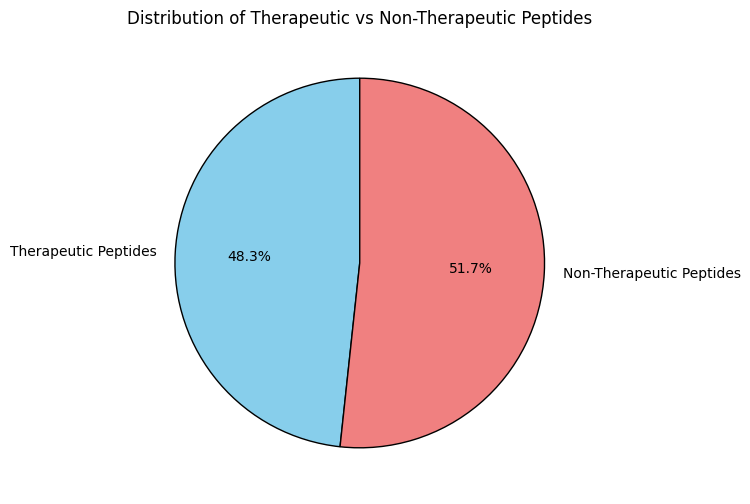

In [5]:
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={"edgecolor": "black"})
plt.title("Distribution of Therapeutic vs Non-Therapeutic Peptides")
plt.show()

### Clean dataset and convert labels

In [6]:
df = df[df["Label"] != "Label"]
df["Label"] = df["Label"].astype(int)

/tmp/ipython-input-6-946718279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Label"] = df["Label"].astype(int)


### Tokenizing peptide sequences

In [7]:
tokenizer = Tokenizer(char_level=True)  # Character-level tokenization
tokenizer.fit_on_texts(df["Sequence"])
sequences = tokenizer.texts_to_sequences(df["Sequence"])

### Padding sequences to the same length

In [8]:
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

### Encode labels

In [9]:
labels = np.array(df["Label"])

### Train-test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

### Convert labels to categorical

In [11]:
num_classes = len(np.unique(labels))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

### Vocabulary size

In [12]:
vocab_size = len(tokenizer.word_index) + 1

### Define model architectures

In [13]:
def build_model(model_type="LSTM"):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(128, return_sequences=True) if model_type == "LSTM" else (
                tf.keras.layers.GRU(128, return_sequences=True) if model_type == "GRU" else tf.keras.layers.SimpleRNN(128, return_sequences=True))
        ),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(64) if model_type == "LSTM" else (
                tf.keras.layers.GRU(64) if model_type == "GRU" else tf.keras.layers.SimpleRNN(64))
        ),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

### Training and evaluation

In [14]:
def train_and_evaluate(model_type):
    model = build_model(model_type)
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
    ]
    history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks, verbose=1)
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"{model_type} Model Accuracy: {accuracy * 100:.2f}%")

    # Generate predictions
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Print classification report and confusion matrix
    print(f"{model_type} Classification Report:\n", classification_report(y_true, y_pred))
    print(f"{model_type} Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    return model, history, accuracy, loss

### Train all models

In [15]:
lstm_model, lstm_history, lstm_acc, lstm_loss = train_and_evaluate("LSTM")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.6995 - loss: 0.5532 - val_accuracy: 0.8732 - val_loss: 0.2941 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8771 - loss: 0.2914 - val_accuracy: 0.8929 - val_loss: 0.2575 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9063 - loss: 0.2398 - val_accuracy: 0.9027 - val_loss: 0.2534 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9155 - loss: 0.2287 - val_accuracy: 0.9015 - val_loss: 0.2394 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9148 - loss: 0.2228 - val_accuracy: 0.9076 - val_loss: 0.2539 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9154 - loss: 0.2198 - val_accuracy: 0.9101 - val_loss: 0.2294 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9215 - loss: 0.2233 - val_ac

In [16]:
gru_model, gru_history, gru_acc, gru_loss = train_and_evaluate("GRU")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6607 - loss: 0.5885 - val_accuracy: 0.8781 - val_loss: 0.3090 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8694 - loss: 0.3295 - val_accuracy: 0.8867 - val_loss: 0.2795 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8927 - loss: 0.2516 - val_accuracy: 0.9002 - val_loss: 0.2509 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9148 - loss: 0.2251 - val_accuracy: 0.9027 - val_loss: 0.2637 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9182 - loss: 0.2234 - val_accuracy: 0.9052 - val_loss: 0.2591 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9239 - loss: 0.2202 - val_accuracy: 0.9052 - val_loss: 0.2564 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9301 - loss: 0.2126 - val_accuracy: 0.90

In [17]:
rnn_model, rnn_history, rnn_acc, rnn_loss = train_and_evaluate("RNN")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 0.7124 - loss: 0.5622 - val_accuracy: 0.8362 - val_loss: 0.3661 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8259 - loss: 0.4030 - val_accuracy: 0.8571 - val_loss: 0.3450 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8643 - loss: 0.3259 - val_accuracy: 0.8781 - val_loss: 0.2955 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8856 - loss: 0.2673 - val_accuracy: 0.8941 - val_loss: 0.2769 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9046 - loss: 0.2365 - val_accuracy: 0.9015 - val_loss: 0.2572 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9177 - loss: 0.2077 - val_accuracy: 0.9015 - val_loss: 0.2654 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9222 - loss: 0.2042 - val_accuracy: 0.

### Plot accuracy and loss comparison

In [18]:
def plot_comparison(metrics, metric_name, title):
    models = ['LSTM', 'GRU', 'RNN']
    values = [metrics['LSTM'], metrics['GRU'], metrics['RNN']]
    plt.figure(figsize=(8, 5))
    plt.bar(models, values, color=['blue', 'green', 'red'])
    plt.xlabel('Model Type')
    plt.ylabel(metric_name)
    plt.title(title)
    plt.show()

### Plot Accuracy and Loss

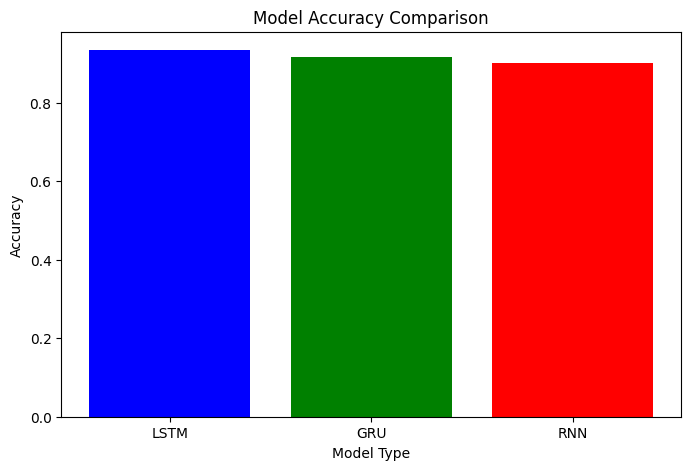

In [19]:
metrics = {'LSTM': lstm_acc, 'GRU': gru_acc, 'RNN': rnn_acc}
plot_comparison(metrics, 'Accuracy', 'Model Accuracy Comparison')

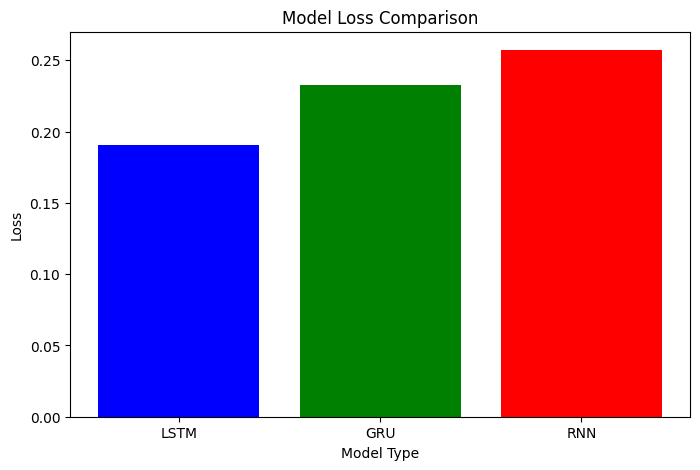

In [20]:
metrics = {'LSTM': lstm_loss, 'GRU': gru_loss, 'RNN': rnn_loss}
plot_comparison(metrics, 'Loss', 'Model Loss Comparison')

### Save trained models

In [21]:
lstm_model.save("lstm_model.h5")
gru_model.save("gru_model.h5")
rnn_model.save("rnn_model.h5")
print("Models saved successfully.")

Models saved successfully.


### Load model when needed

In [22]:
loaded_lstm_model = load_model("lstm_model.h5")
loaded_gru_model = load_model("gru_model.h5")
loaded_rnn_model = load_model("rnn_model.h5")
print("Models loaded successfully.")

Models loaded successfully.


### Testing the models

In [23]:
def predict_peptide(model, tokenizer, sequence, max_length):
    # Convert sequence to tokenized form
    seq_tokenized = tokenizer.texts_to_sequences([sequence])

    # Pad sequence to match training dimensions
    seq_padded = pad_sequences(seq_tokenized, maxlen=max_length, padding='post')

    # Make prediction
    pred = model.predict(seq_padded, verbose=0)

    # Get class label and confidence
    predicted_class = np.argmax(pred)
    confidence = pred[0][1]  # Confidence for therapeutic class (1)
    return predicted_class, confidence

### Find critical motifs for a single peptide

In [24]:
def find_critical_motifs(model, tokenizer, sequence, max_length, window_sizes=[3, 4, 5], threshold=0.1):
    original_class, original_confidence = predict_peptide(model, tokenizer, sequence, max_length)
    if original_class != 1:
        return None, None, f"Peptide '{sequence}' not predicted as therapeutic (Class: {original_class})"

    motifs = []
    motif_effects = []

    for window_size in window_sizes:
        if len(sequence) < window_size:
            continue
        for i in range(len(sequence) - window_size + 1):
            motif = sequence[i:i + window_size]
            modified_sequence = sequence[:i] + sequence[i + window_size:]
            mod_class, mod_confidence = predict_peptide(model, tokenizer, modified_sequence, max_length)

            # Consider motif critical if confidence drops significantly, even if class doesn't flip
            if original_confidence - mod_confidence > threshold:
                motifs.append(motif)
                motif_effects.append({
                    "Motif": motif,
                    "Original Confidence": original_confidence,
                    "Modified Confidence": mod_confidence,
                    "Modified Sequence": modified_sequence
                })

    return motifs, motif_effects, None

### Example peptide sequence for prediction

In [25]:
peptides = [
    ("KWKKLLKKPPPLLKKLLKKL", 1),
    ("PKKKSYLILSVCHCQHIP", 0),
    ("RMCKTPSGKFKGYCVNNTNCKNVCRTEGFPTGSCDFHVAGRKCYCYKPCP", 1),
    ("lKKllKKllKKl", 1),
    ("YFITIATKSAGFMVDDYWGH", 0),
    ("LVATGMAAGVAKTIVNAVSAGMDIATALSLFSGAFTAAGGIMALIKKYAQ", 1),
    ("WFRKQLKW", 1),
    ("HWWYPYAVRHDLRYHFWCTHTTSK", 0),
    ("MKTLVLLCVLAVF", 0),
    ("CLSGRYKGPCAVWDNETCRRVCKEEGRSSGHCSPSLKCWCEGC", 1),
    ("LIPKNGFKLS", 0),
    ("FLPLIGRVLSGIL", 1),
    ("VWRNHIPHNCAIWHYGEGKQDWSHSAKWIE", 0),
    ("RIDPEAQFWHYS", 0),
    ("LLSLVPHAINAVSAIAKHF", 1),
    ("GELGRLVYLLDGPGYDPIHCD", 1),
    ("TTLQFHYSKTPHVYM", 0),
    ("GFWGKLFKLGLHGIGLLHLHL", 1),
    ("WIVCTTQVKTQWFWP", 0)
]

### Initialize accuracy counters and motif results

In [26]:
accuracies = {"LSTM": 0, "GRU": 0, "RNN": 0}
motif_results = {"LSTM": [], "GRU": [], "RNN": []}

### Models dictionary

In [27]:
models = {
    "LSTM": loaded_lstm_model,
    "GRU": loaded_gru_model,
    "RNN": loaded_rnn_model
}

### Parameters for motif finding

In [28]:
window_sizes = [3, 4, 5]  # Test multiple window sizes
confidence_threshold = 0.1  # Lowered threshold for more sensitivity

### Run predictions, calculate accuracy, and perform motif analysis

In [29]:
for sequence, true_label in peptides:
    for model_name, model in models.items():
        pred_class, _ = predict_peptide(model, tokenizer, sequence, max_length)
        accuracies[model_name] += int(pred_class == true_label)
        print(f"{model_name} - Sequence: {sequence}, Predicted Class: {pred_class}")

        motifs, motif_effects, error = find_critical_motifs(
            model, tokenizer, sequence, max_length, window_sizes, confidence_threshold
        )
        result = {
            "Sequence": sequence,
            "True Label": true_label,
            "Predicted Class": pred_class,
            "Motifs": motifs if motifs else [],
            "Motif Effects": motif_effects if motif_effects else [],
            "Error": error
        }
        motif_results[model_name].append(result)

LSTM - Sequence: KWKKLLKKPPPLLKKLLKKL, Predicted Class: 1
GRU - Sequence: KWKKLLKKPPPLLKKLLKKL, Predicted Class: 1
RNN - Sequence: KWKKLLKKPPPLLKKLLKKL, Predicted Class: 1
LSTM - Sequence: PKKKSYLILSVCHCQHIP, Predicted Class: 0
GRU - Sequence: PKKKSYLILSVCHCQHIP, Predicted Class: 0
RNN - Sequence: PKKKSYLILSVCHCQHIP, Predicted Class: 0
LSTM - Sequence: RMCKTPSGKFKGYCVNNTNCKNVCRTEGFPTGSCDFHVAGRKCYCYKPCP, Predicted Class: 1
GRU - Sequence: RMCKTPSGKFKGYCVNNTNCKNVCRTEGFPTGSCDFHVAGRKCYCYKPCP, Predicted Class: 1
RNN - Sequence: RMCKTPSGKFKGYCVNNTNCKNVCRTEGFPTGSCDFHVAGRKCYCYKPCP, Predicted Class: 1
LSTM - Sequence: lKKllKKllKKl, Predicted Class: 1
GRU - Sequence: lKKllKKllKKl, Predicted Class: 1
RNN - Sequence: lKKllKKllKKl, Predicted Class: 1
LSTM - Sequence: YFITIATKSAGFMVDDYWGH, Predicted Class: 0
GRU - Sequence: YFITIATKSAGFMVDDYWGH, Predicted Class: 0
RNN - Sequence: YFITIATKSAGFMVDDYWGH, Predicted Class: 0
LSTM - Sequence: LVATGMAAGVAKTIVNAVSAGMDIATALSLFSGAFTAAGGIMALIKKYAQ, Predicted C

### Calculate percentage accuracy

In [30]:
total_samples = len(peptides)
accuracies = {model: (correct / total_samples) * 100 for model, correct in accuracies.items()}

### Print accuracy results

In [31]:
print("Model Accuracies:")
for model, accuracy in accuracies.items():
    print(f"{model}: {accuracy:.2f}%")

Model Accuracies:
LSTM: 89.47%
GRU: 89.47%
RNN: 94.74%


### Print motif analysis results

In [32]:
print("Motif Analysis Results (Therapeutic Peptides Only):")
for model_name, model_results in motif_results.items():
    print(f"\n{model_name}:")
    for res in model_results:
        if res["True Label"] == 1:  # Only print therapeutic peptides
            print(f"Sequence: {res['Sequence']}")
            print(f"Predicted Class: {res['Predicted Class']}")
            if res["Error"]:
                print(f"Error: {res['Error']}")
            else:
                print(f"Critical Motifs Found: {res['Motifs']}")
                if res["Motifs"]:
                    for effect in res["Motif Effects"][:3]:  # Limit to top 3 motifs for brevity
                        print(f"  Motif: {effect['Motif']}")
                        print(f"  Original Confidence: {effect['Original Confidence']:.3f}")
                        print(f"  Modified Confidence: {effect['Modified Confidence']:.3f}")
                        print(f"  Modified Sequence: {effect['Modified Sequence']}")
                    if len(res["Motif Effects"]) > 3:
                        print(f"  ...and {len(res['Motif Effects']) - 3} more motifs")
            print("-" * 50)

Motif Analysis Results (Therapeutic Peptides Only):

LSTM:
Sequence: KWKKLLKKPPPLLKKLLKKL
Predicted Class: 1
Critical Motifs Found: []
--------------------------------------------------
Sequence: RMCKTPSGKFKGYCVNNTNCKNVCRTEGFPTGSCDFHVAGRKCYCYKPCP
Predicted Class: 1
Critical Motifs Found: []
--------------------------------------------------
Sequence: lKKllKKllKKl
Predicted Class: 1
Critical Motifs Found: []
--------------------------------------------------
Sequence: LVATGMAAGVAKTIVNAVSAGMDIATALSLFSGAFTAAGGIMALIKKYAQ
Predicted Class: 1
Critical Motifs Found: []
--------------------------------------------------
Sequence: WFRKQLKW
Predicted Class: 1
Critical Motifs Found: []
--------------------------------------------------
Sequence: CLSGRYKGPCAVWDNETCRRVCKEEGRSSGHCSPSLKCWCEGC
Predicted Class: 1
Critical Motifs Found: []
--------------------------------------------------
Sequence: FLPLIGRVLSGIL
Predicted Class: 1
Critical Motifs Found: ['FLPL']
  Motif: FLPL
  Original Confidence: 0.99

### Summarize motif impact

In [33]:
for model_name, model_results in motif_results.items():
    therapeutic_count = sum(1 for res in model_results if res["True Label"] == 1)
    motif_found_count = sum(1 for res in model_results if res["True Label"] == 1 and res["Motifs"])
    if therapeutic_count > 0:
        motif_percentage = (motif_found_count / therapeutic_count) * 100
        print(f"{model_name}: Found critical motifs in {motif_found_count}/{therapeutic_count} therapeutic peptides ({motif_percentage:.2f}%)")

LSTM: Found critical motifs in 2/10 therapeutic peptides (20.00%)
GRU: Found critical motifs in 2/10 therapeutic peptides (20.00%)
RNN: Found critical motifs in 7/10 therapeutic peptides (70.00%)
